torch.Size([100, 1, 1]) torch.Size([100, 1, 1])


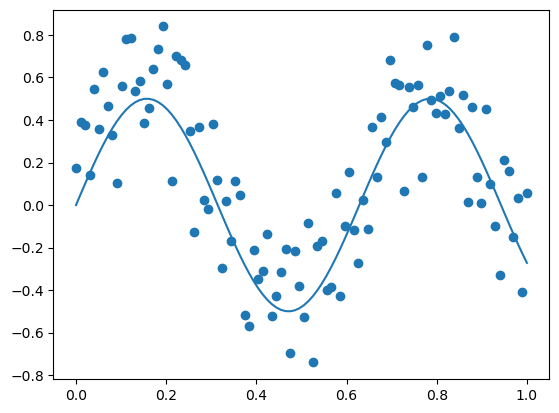

In [137]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn as nn

device = 'cuda'

def make_fake_data():

    x = np.linspace(0, 1, 100)

    y_real = 0.5*np.sin(10*x)
    y_measured = y_real+ 0.75*(np.random.rand(len(x))-.5)

    x = torch.tensor(x[:, None, None], dtype = torch.float32, device = device)
    y = torch.tensor(y_measured[:, None, None], dtype = torch.float32, device = device)
    y_real = torch.tensor(y_real[:, None, None], dtype = torch.float32, device = device)

    print(x.shape, y.shape)

    return x, y, y_real

def t2n(x):
    return x.cpu().detach().numpy().squeeze()


x, y, y_real = make_fake_data()
fig, ax = plt.subplots()
ax.plot(t2n(x), t2n(y_real))
ax.scatter(t2n(x), t2n(y))


In [138]:
class NNmodel(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.layer1 = nn.Linear(1, N)
        self.layer2 = nn.Linear(N, N)
        self.layer3 = nn.Linear(N, 1)
        self.act = nn.Tanh()
 
    def forward(self, x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x)
        x = self.act(x)
        x = self.layer3(x)
        x = self.act(x)
        return x
 

def train_model(N):

    model = NNmodel(N=N).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

    losses = []
    for i in range(10000):
        optimizer.zero_grad()

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        loss = loss.detach().cpu().numpy()
        losses.append(loss)
        if i %1000 ==0:
            print(f'{i}: {loss}')

    x_smooth = torch.tensor(np.linspace(0, 1, 100)[:, None, None], dtype = torch.float32, device = device)
    y_pred = model(x_smooth)
    ax.plot(x_smooth.detach().cpu().numpy().squeeze(), y_pred.detach().cpu().numpy().squeeze())

    return model, losses, x_smooth, y_pred

results = {}
for N in [1, 3, 50]:
    results[N] = train_model(N=N)
    
    #model, losses, x_smooth, y_pred = train_model(N=2)



0: 0.19152037799358368
1000: 0.1455380916595459
2000: 0.13822013139724731
3000: 0.13403557240962982
4000: 0.1323901116847992
5000: 0.12996536493301392
6000: 0.12382566183805466
7000: 0.1157471090555191
8000: 0.1139381155371666
9000: 0.11316299438476562
0: 0.882583737373352
1000: 0.1493898183107376
2000: 0.1430579274892807
3000: 0.13413578271865845
4000: 0.10040084272623062
5000: 0.06871529668569565
6000: 0.06384225934743881
7000: 0.04095461219549179
8000: 0.04005679115653038
9000: 0.039997510612010956
0: 0.22760547697544098
1000: 0.040091995149850845
2000: 0.039178598672151566
3000: 0.03792073577642441
4000: 0.03771250322461128
5000: 0.03721344470977783
6000: 0.03671667352318764
7000: 0.03528735414147377
8000: 0.033300962299108505
9000: 0.03259247913956642


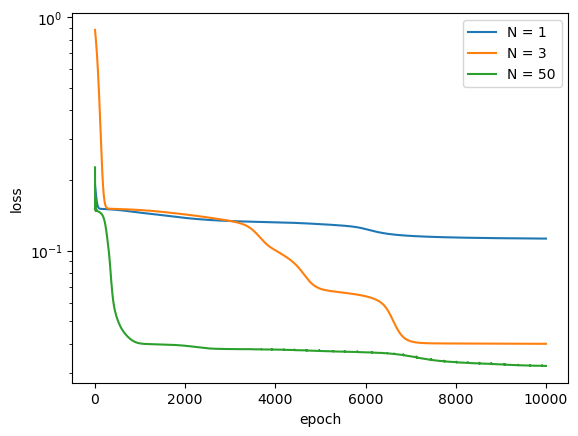

In [139]:

fig, ax = plt.subplots()
ax.set_yscale('log')
for key, val in results.items():
    ax.plot(val[1], label = f'N = {key}')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

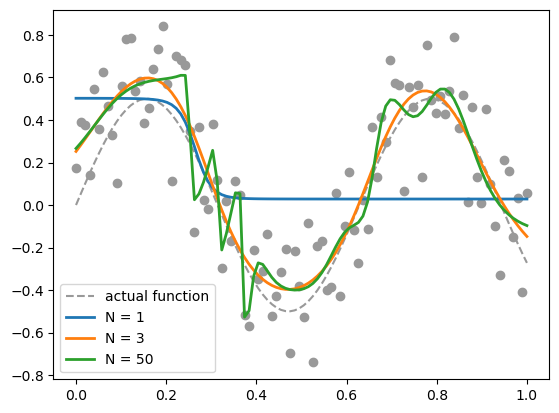

In [143]:
fig, ax = plt.subplots()

ax.plot(t2n(x), t2n(y_real), linestyle = '--', color = (.6, .6, .6), label = 'actual function')
ax.scatter(t2n(x), t2n(y), color = (.6, .6, .6))
for key, val in results.items():
    ax.plot(t2n(val[2]), t2n(val[3]), label = f'N = {key}', linewidth = 2)

ax.legend()

fig.savefig('fit.svg')